<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Bot basado en reglas con DNN + Spacy

#### Datos
Este ejemplo se inspiró en otro Bot en inglés creado con NLTK, lo tienen como referencia para hacer lo mismo en inglés:\
[LINK](https://towardsdatascience.com/a-simple-chatbot-in-python-with-deep-learning-3e8669997758)

### 1 - Instalar dependencias
Para poder utilizar Spacy en castellano es necesario agregar la librería "spacy-stanza" para lematizar palabras en español.

In [1]:
# La última versión de spacy-stanza (>1.0) es compatible solo con spacy >=3.0
# Nota: spacy 3.0 incorpora al pepiline nlp transformers
import json
import string
import random 
import numpy as np

import tensorflow as tf 
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense, Dropout

In [2]:
import stanza
import spacy_stanza

# Vamos a usar SpaCy-Stanza. Stanza es una librería de NLP de Stanford
# SpaCy armó un wrapper para los pipelines y modelos de Stanza
# https://stanfordnlp.github.io/stanza/

# Descargar el diccionario en español y armar el pipeline de NLP con spacy
stanza.download("es")
nlp = spacy_stanza.load_pipeline("es")

c:\users\lucas\documents\especialización en inteligencia artificial de la uba\10. procesamiento del lenguaje natural\repositorio propio\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-09-15 16:55:09 INFO: Downloading default packages for language: es (Spanish)...
2022-09-15 16:55:10 INFO: File exists: C:\Users\lucas\stanza_resources\es\default.zip.
2022-09-15 16:55:16 INFO: Finished downloading models and saved to C:\Users\lucas\stanza_resources.
2022-09-15 16:55:16 INFO: Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |
| depparse  | ancora  |
| ner       | conll02 |

2022-09-15 16:55:16 INFO: Use device: cpu
2022-09-15 16:55:16 INFO: Loading: tokenize
2022-09-15

### 2 - Herramientas de preprocesamiento de datos
Entre las tareas de procesamiento de texto en español se implementa:
- Quitar acentos y caracteres especiales
- Quitar números
- Quitar símbolos de puntuación

In [3]:
import re
import unicodedata

# El preprocesamento en castellano requiere más trabajo

# Referencia de regex:
# https://docs.python.org/3/library/re.html

def preprocess_clean_text(text):    
    # sacar tildes de las palabras:
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # quitar caracteres especiales
    pattern = r'[^a-zA-z0-9.,!?/:;\"\'\s]' # [^ : ningún caracter de todos estos
    # (termina eliminando cualquier caracter distinto de los del regex)
    text = re.sub(pattern, '', text)
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' # igual al anterior pero sin cifras numéricas
    # quitar números
    text = re.sub(pattern, '', text)
    # quitar caracteres de puntuación
    text = ''.join([c for c in text if c not in string.punctuation])
    return text

In [4]:
text = "personas Ideas! estás cosas y los peces y los murciélagos"

# Antes de preprocesar los datos se pasa a minúsculas todo el texto
preprocess_clean_text(text.lower())

'personas ideas estas cosas y los peces y los murcielagos'

In [5]:
# Ejemplo de como fuciona
text = "hola personas Ideas! estás cosas y los peces y los murciélagos"

# Antes de preprocesar los datos se pasa a minúsculas todo el texto
tokes = nlp(preprocess_clean_text(text.lower()))
print("tokens:", tokes)
print("Lematización de cada token:")
for token in tokes:
    print([token, token.lemma_])

tokens: hola personas ideas estas cosas y los peces y los murcielagos
Lematización de cada token:
[hola, 'holar']
[personas, 'persona']
[ideas, 'idea']
[estas, 'este']
[cosas, 'cosa']
[y, 'y']
[los, 'el']
[peces, 'pez']
[y, 'y']
[los, 'el']
[murcielagos, 'murcielago']


### 3 - Diccionario de entrada

- Preguntas frecuentes de anfitriones de Airbnb (disponibles [aquí](https://www.airbnb.com.ar/resources/hosting-homes/t/common-questions-23) y adaptadas).

In [6]:
# Dataset en formato JSON que representa las posibles preguntas (patterns)
# y las posibles respuestas por categoría (tag)
# Los "patterns" van a formar el corpus para entrenar el clasificador que clasifica en tags
# "respones" son las respuestas predeterminadas posibles para cada tag
dataset = {
    "intents": [
        {
            "tag": "cancel",
            "patterns": ["¿Qué pasa cuando los huéspedes cancelan una reserva?",
                         "¿Qué pasa cuando los huéspedes modifican una reserva?",],
            "responses": ["Si un huésped cancela una reserva, vamos a aplicar tu política de cancelación.",
                          "Si aceptás un cambio en la reserva de un huésped, vas a recibir el pago 24 horas "+
                          "después de la nueva hora del check-in", "Elegí la política de cancelación que mejor "+
                          "se adapte a tus necesidades.",],
        },
        {
            "tag": "forest_fires",
            "patterns": ["¿Cómo prepararse para los incendios forestales?",],
            "responses": ["Trabajamos con la Asociación Internacional de Jefes de Cuerpo de Bomberos para "+
                          "asesorarnos sobre la seguridad ante incendios forestales.", 
                          "Seguí los consejos de los bomberos", "Comunicate con tus huéspedes "+ 
                          "de manera clara para prepararlos en caso de un incendio forestal.",],
        },
        {
            "tag": "prevent_parties",
            "patterns": ["Consejos para ayudarte a prevenir las fiestas en tu propiedad",
                         "Evitar festejos en tu propiedad",],
            "responses": ["La política sobre fiestas y eventos de Airbnb te permite cancelar sin sanciones "+
                          "si brindás pruebas que demuestren que un huésped tiene intenciones de hacer una fiesta.",
                          "Definir expectativas y establecer una comunicación clara pueden ayudar a evitar problemas",],
        },
        {
            "tag": "positioning",
            "patterns": ["Consejos para mejorar tu posicionamiento en los resultados de búsqueda en Airbnb", 
                         "¿Cómo posicionarse mejor en Airbnb?",],
            "responses": ["Hay muchos factores que determinan la posición de los anuncios en los resultados de búsqueda.",
                          "Para mejorar el posicionamiento de tu anuncio, te recomendamos que pongas un precio atractivo, "+
                          "aceptes más reservas y te esfuerces por llegar a ser Superanfitrión.",],
        },
        {
            "tag": "get_started",
            "patterns": ["¿Cómo empezar tu negocio en Airbnb?", "Comenzar tu negocio en Airbnb",],
            "responses": ["Calculá cuánto podrías ganar", "Aprendé a administrar tu negocio", 
                          "Convertite en anfitrión en Airbnb [link]",],
        },
        {
            "tag": "insurance",
            "patterns": ["Seguro de viaje para las reservas", "Asegurar huéspedes", "Seguro viajeros",], 
            "responses": ["El seguro de viaje paga a los viajeros hasta el 100 % de los costos de la reserva en "+
                          "Airbnb si cancelan por motivos cubiertos", "Los huéspedes en Estados Unidos, el Reino Unido "+
                          "y ocho países de Europa pronto van a poder agregar un seguro de viaje cuando reserven una estadía",],
        },
        {
            "tag": "protect_host",
            "patterns": ["¿Cómo protegemos a los anfitriones en Airbnb?", "¿Cómo me protegen?",],
            "responses": ["Airbnb toma las precauciones necesarias para proteger a los anfitriones y los huéspedes.",
                          "Contás con ayuda disponible en todo el mundo y en 11 idiomas distintos, "+
                          "las 24 horas, los 7 días de la semana.", "Consultá nuestra guía completa [link] "+ 
                          "y descubrí el mundo de los anfitriones.",],
        },
        {
            "tag": "aircover",
            "patterns": ["Todo lo que necesitás saber sobre AirCover para anfitriones", "¿Qué es aircover?",],
            "responses": ["AirCover para anfitriones incluye una Protección ante daños para anfitriones "+
                          "de 1 millón de dólares y un Seguro de responsabilidad civil para anfitriones de "+
                          "1 millón de dólares", "La Protección ante daños incluye la protección por pérdida de ingresos, "+
                          "así como también los daños causados por mascotas, los gastos por limpieza profunda y mucho más.",],
        },
        {
            "tag": "schedule",
            "patterns": ["¿Cómo funciona la configuración del calendario de tus reservas?", 
                         "Configurar calendario", "Calendario de reservas",],
            "responses": ["Mantené la configuración de tu calendario actualizada para conseguir reservas cuando vos quieras.",
                          "Sincronizá tus calendarios para evitar cancelaciones y sanciones.",
                          "Encontrá más información en nuestra guía completa para crear un anuncio exitoso. [link]",],
        },
        {
            "tag": "recommendations",
            "patterns": ["Conocé las recomendaciones para hospedar", "¿Qué me recomendarían para hospedar?",],
            "responses": ["Respondé a los mensajes de los huéspedes y a cualquier mensaje relacionado con las "+
                          "reservas en un plazo de 24 horas.", "Establecé requisitos de reserva para sentirte "+
                          "a gusto aceptando más huéspedes.", "Para evitar cancelaciones, mantené tu calendario "+
                          "siempre actualizado.", "Seguí los estándares de hospitalidad de Airbnb para conseguir "+
                          "evaluaciones excelentes.", "Hablá con un anfitrión experimentado.",
                          "Consultá nuestra guía completa y descubrí el mundo de los anfitriones. [link]",],
        },
    ]
}

### 4 - Preprocesamiento y armado del dataset

In [7]:
# Datos que necesitaremos, las palabras o vocabulario
words = []
classes = []
doc_X = []
doc_y = []

# Por cada intención (intents) debemos tomar los patrones que la caracterízan
# a esa intención y transformarla a tokens para almacenar en doc_X

# El tag de cada intención se almacena como doc_Y (la clase a predecir)
# En `words` vamos a guardar el vocabulario
# En `class` las posibles clases o tags

for intent in dataset["intents"]:
    for pattern in intent["patterns"]:
        # trasformar el patron a tokens
        tokens = nlp(preprocess_clean_text(pattern.lower()))
        # lematizar los tokens
        for token in tokens:            
            words.append(token.lemma_)
        
        doc_X.append(pattern)
        doc_y.append(intent["tag"])
    
    # Agregar el tag a las clases
    if intent["tag"] not in classes:
        classes.append(intent["tag"])

# Elminar duplicados con "set" y ordenar el vocubulario y las clases por orden alfabético
words = sorted(set(words))
classes = sorted(set(classes))

c:\users\lucas\documents\especialización en inteligencia artificial de la uba\10. procesamiento del lenguaje natural\repositorio propio\venv\lib\site-packages\stanza\models\common\beam.py:86: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  prevK = bestScoresId // numWords
C:\Users\lucas\AppData\Local\Temp\ipykernel_8328\2762758537.py:17: UserWarning: Due to multiword token expansion or an alignment issue, the original text has been replaced by space-separated expanded tokens.
  tokens = nlp(preprocess_clean_text(pattern.lower()))
C:\Users\lucas\AppData\Local\Temp\ipykernel_8328\2762758537.py:17: UserWarning: Can't set named entities because of multi-word token e

In [8]:
print("words:", words)
print("classes:", classes)
print("doc_X:", doc_X)
print("doc_y:", doc_y)

words: ['a', 'airbnb', 'aircover', 'anfitrión', 'asegurar', 'ayudar', 'busqueda', 'calendario', 'cancelar', 'comenzar', 'como', 'configuracion', 'configurar', 'conocer', 'consejo', 'cuando', 'de', 'el', 'empezar', 'en', 'evitar', 'festejo', 'fiesta', 'forestal', 'funcionar', 'hospedar', 'huesped', 'incendio', 'mejor', 'mejorar', 'modificar', 'necesitar', 'negocio', 'para', 'pasar', 'posicionamiento', 'posicionar', 'preparar', 'prevenir', 'propiedad', 'proteger', 'que', 'recomendación', 'recomendar', 'reserva', 'resultado', 'saber', 'seguro', 'ser', 'sobre', 'todo', 'tu', 'tú', 'uno', 'viaje', 'viajero', 'yo', 'él']
classes: ['aircover', 'cancel', 'forest_fires', 'get_started', 'insurance', 'positioning', 'prevent_parties', 'protect_host', 'recommendations', 'schedule']
doc_X: ['¿Qué pasa cuando los huéspedes cancelan una reserva?', '¿Qué pasa cuando los huéspedes modifican una reserva?', '¿Cómo prepararse para los incendios forestales?', 'Consejos para ayudarte a prevenir las fiestas e

In [9]:
# Tamaño del vocabulario
print("Vocabulario:", len(words))

Vocabulario: 58


In [10]:
# Cantidad de tags
print("Tags:", len(classes))

Tags: 10


In [11]:
# Transformar doc_X en bag of words por oneHotEncoding
# Transformar doc_Y en un vector de clases multicategórico con oneHotEncoding

training = []
out_empty = [0] * len(classes)

for idx, doc in enumerate(doc_X):
    # Transformar la pregunta (input) en tokens y lematizar
    text = []
    tokens = nlp(preprocess_clean_text(doc.lower()))
    for token in tokens:
        text.append(token.lemma_)

    # Transformar los tokens en "Bag of words" (arrays de 1 y 0)
    bow = []
    for word in words:
        bow.append(1) if word in text else bow.append(0)
    
    # Crear el array de salida (class output) correspondiente
    output_row = list(out_empty)
    output_row[classes.index(doc_y[idx])] = 1

    print("X:", bow, "y:", output_row)
    training.append([bow, output_row])

# Mezclar los datos
random.shuffle(training)
training = np.array(training, dtype=object)
# Dividir en datos de entrada y salida
train_X = np.array(list(training[:, 0]))
train_y = np.array(list(training[:, 1]))

X: [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] y: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
X: [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0] y: [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

C:\Users\lucas\AppData\Local\Temp\ipykernel_8328\220604768.py:10: UserWarning: Due to multiword token expansion or an alignment issue, the original text has been replaced by space-separated expanded tokens.
  tokens = nlp(preprocess_clean_text(doc.lower()))
C:\Users\lucas\AppData\Local\Temp\ipykernel_8328\220604768.py:10: UserWarning: Can't set named entities because of multi-word token expansion or because the character offsets don't map to valid tokens produced by the Stanza tokenizer:
Words: ['como', 'funciona', 'la', 'configuracion', 'de', 'el', 'calendario', 'de', 'tus', 'reservas']
Entities: []
  tokens = nlp(preprocess_clean_text(doc.lower()))


X: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0] y: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
X: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
X: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0

### 5 - Entrenamiento del modelo

In [12]:
# Shape de entrada y salida
input_shape = (train_X.shape[1],)
output_shape = train_y.shape[1]
print("input:", input_shape, "output:", output_shape)

input: (58,) output: 10


In [13]:
# Entrenamiento del modelo DNN
# - Modelo secuencial
# - Con regularización
# - softmax y optimizador Adam
model = Sequential()
model.add(Dense(128, input_shape=input_shape, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(output_shape, activation = "softmax"))

model.compile(loss='categorical_crossentropy',
              optimizer="Adam",
              metrics=["accuracy"])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               7552      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
Total params: 16,458
Trainable params: 16,458
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
hist = model.fit(x=train_X, y=train_y, epochs=200)

Epoch 1/200
1/1 [==============================] - 1s 678ms/step - loss: 2.2804 - accuracy: 0.0952
Epoch 2/200
1/1 [==============================] - 0s 9ms/step - loss: 2.1901 - accuracy: 0.1905
Epoch 3/200
1/1 [==============================] - 0s 11ms/step - loss: 2.3437 - accuracy: 0.0952
Epoch 4/200
1/1 [==============================] - 0s 8ms/step - loss: 2.2913 - accuracy: 0.0952
Epoch 5/200
1/1 [==============================] - 0s 9ms/step - loss: 2.3153 - accuracy: 0.1429
Epoch 6/200
1/1 [==============================] - 0s 6ms/step - loss: 2.3057 - accuracy: 0.0952
Epoch 7/200
1/1 [==============================] - 0s 8ms/step - loss: 2.2098 - accuracy: 0.2381
Epoch 8/200
1/1 [==============================] - 0s 8ms/step - loss: 2.2377 - accuracy: 0.1429
Epoch 9/200
1/1 [==============================] - 0s 12ms/step - loss: 2.2378 - accuracy: 0.1905
Epoch 10/200
1/1 [==============================] - 0s 10ms/step - loss: 2.2024 - accuracy: 0.1429
Epoch 11/200
1/1 [======

1/1 [==============================] - 0s 7ms/step - loss: 0.1752 - accuracy: 0.9524
Epoch 168/200
1/1 [==============================] - 0s 8ms/step - loss: 0.1977 - accuracy: 0.9524
Epoch 169/200
1/1 [==============================] - 0s 8ms/step - loss: 0.1313 - accuracy: 1.0000
Epoch 170/200
1/1 [==============================] - 0s 7ms/step - loss: 0.1993 - accuracy: 1.0000
Epoch 171/200
1/1 [==============================] - 0s 6ms/step - loss: 0.1749 - accuracy: 1.0000
Epoch 172/200
1/1 [==============================] - 0s 7ms/step - loss: 0.2278 - accuracy: 0.9524
Epoch 173/200
1/1 [==============================] - 0s 7ms/step - loss: 0.1438 - accuracy: 1.0000
Epoch 174/200
1/1 [==============================] - 0s 6ms/step - loss: 0.1616 - accuracy: 1.0000
Epoch 175/200
1/1 [==============================] - 0s 6ms/step - loss: 0.0952 - accuracy: 1.0000
Epoch 176/200
1/1 [==============================] - 0s 6ms/step - loss: 0.2347 - accuracy: 0.9048
Epoch 177/200
1/1 [=====

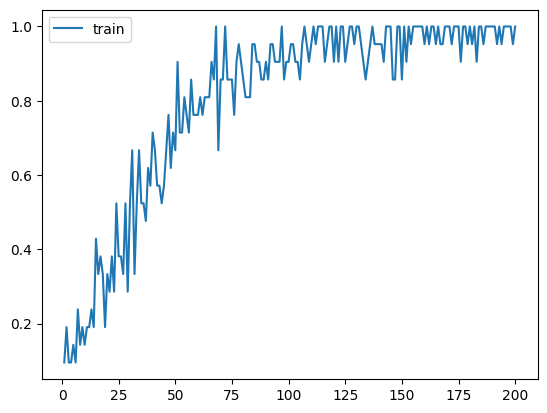

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
plt.show()

In [16]:
# Guardar lo necesario para poder re-utilizar este modelo en el futuro
# el vocabulario utilizado (words)
# las posibles clases
# el modelo
import pickle
pickle.dump(words, open('words.pkl','wb'))
pickle.dump(classes, open('classes.pkl','wb'))
model.save('chatbot_model.h5')

### 6 - Testing y validación

In [17]:
# convertir texto de entrada del usuario a tokens
def text_to_tokens(text):
    lemma_tokens = []
    tokens = nlp(preprocess_clean_text(text.lower()))
    for token in tokens:
        lemma_tokens.append(token.lemma_)
    #print(lemma_tokens)
    return lemma_tokens

# transformar el texto de entrada tokenizado a una representación OHE
def bag_of_words(text, vocab): 
    tokens = text_to_tokens(text)
    bow = [0] * len(vocab)
    for w in tokens: 
        for idx, word in enumerate(vocab):
            if word == w: 
                bow[idx] = 1
    #print(bow)
    return np.array(bow)

# usar modelo con la entrada en OHE y los labels posibles (tags)
def pred_class(text, vocab, labels): 
    bow = bag_of_words(text, vocab)
    words_recognized = sum(bow)

    return_list = []
    if words_recognized > 0: # sólo si reconoció alguna palabra del vocabulario
        result = model.predict(np.array([bow]))[0] # es un array de softmax
        thresh = 0.2
        # filtrar aquellas entradas menores al umbral `thresh`
        y_pred = [[idx, res] for idx, res in enumerate(result) if res > thresh]
        # ordenar keys de acuerdo al valor softmax
        y_pred.sort(key=lambda x: x[1], reverse=True)
    
        # return_list es una lista de los labels de mayor a menor
        for r in y_pred:
            return_list.append(labels[r[0]])
            #print(labels[r[0]], r[1])

    # si no reconoció palabras del vocabulario se devuelve una lista vacía
    return return_list

# obtener una respuesta predeterminada 
def get_response(intents_list, intents_json):
    tag = intents_list[0] # tomar el tag con el mejor valor softmax
    list_of_intents = intents_json["intents"] # intents_json es todo el dataset
    for i in list_of_intents: 
        if i["tag"] == tag: # buscar el tag correspoindiente y dar una respuesta predeterminada aleatoria 
            result = "BOT: " + random.choice(i["responses"])
            break
    return result

In [ ]:
while True:
    # pedir input al usuario
    message = input("")
    # 
    intents = pred_class(message, words, classes)
    if len(intents) > 0:
        result = get_response(intents, dataset)
        print(result)
    else: # si no hubo ningún resultado que supere el umbral
        print("Perdón, no comprendo la pregunta.")

aircover
1/1 [==============================] - 0s 125ms/step
BOT: AirCover para anfitriones incluye una Protección ante daños para anfitriones de 1 millón de dólares y un Seguro de responsabilidad civil para anfitriones de 1 millón de dólares
airtag
Perdón, no comprendo la pregunta.
calendario
1/1 [==============================] - 0s 31ms/step
BOT: Mantené la configuración de tu calendario actualizada para conseguir reservas cuando vos quieras.
¿Cómo configurar el calendario?
1/1 [==============================] - 0s 31ms/step
BOT: Mantené la configuración de tu calendario actualizada para conseguir reservas cuando vos quieras.
recomendaciones
1/1 [==============================] - 0s 47ms/step
BOT: Hablá con un anfitrión experimentado.
Necesito recomendaciones
1/1 [==============================] - 0s 33ms/step
BOT: Sincronizá tus calendarios para evitar cancelaciones y sanciones.
evitar fiestas en mi domicilio
1/1 [==============================] - 0s 31ms/step
BOT: Definir expecta

### 7 - Conclusiones
El bot está definido para responder 10 de las preguntas más frecuentes de los huéspedes de Airbnb. El dataset se armó a partir del material disponible en el siguiente enlace: [Centro de recursos](https://www.airbnb.com.ar/resources/hosting-homes/t/common-questions-23). Luego de realizarle algunas consultas, notamos que el bot es capaz de responder a la mayoría de ellas correctamente. 
Luego de experimentar con diferentes arquitecturas (añadiendo capas a la red neuronal) y también con diferentes hiperparámetros (como el número de epochs), el modelo que mejor funcionó es el propuesto.